# Unit conversion in post-processing

This feature is available from version 1.0.14.

This document shows how to use opstool to perform unit conversion.

To maintain the flexibility of using OpenSeesPy, opstool implements unit conversion methods in both pre-processing and post-processing.

Pre-processing: [opstool.pre.UnitSystem](https://opstool.readthedocs.io/en/latest/src/api/_autosummary/opstool.pre.UnitSystem.html#opstool.pre.UnitSystem)

Post-processing: [opstool.post.update_unit_system]()

Note that these two do not need to be run at the same time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import openseespy.opensees as ops
import opstool as opst

We use the following two-dimensional truss structure:

## model

We use [Automatic Unit Conversion](https://opstool.readthedocs.io/en/latest/src/pre/unit_system.html) to set the basic unit used by the model, which is the lowest level unit system. Then we can easily define the units of various physical quantities.

In [2]:
def model(length_unit, force_unit):
    UNIT = opst.pre.UnitSystem(length=length_unit, force=force_unit)
    ops.wipe()
    ops.model("basic", "-ndm", 2, "-ndf", 2)
    # create nodes
    ops.node(1, 0, 0)
    ops.node(2, 144.0 * UNIT.cm, 0)
    ops.node(3, 2.0 * UNIT.m, 0)
    ops.node(4, 80.0 * UNIT.cm, 96.0 * UNIT.cm)
    ops.mass(4, 100 * UNIT.kg, 100 * UNIT.kg)
    # set boundary condition
    ops.fix(1, 1, 1)
    ops.fix(2, 1, 1)
    ops.fix(3, 1, 1)
    # define materials
    ops.uniaxialMaterial("Elastic", 1, 3000.0 * UNIT.N / UNIT.cm2)
    # define elements
    ops.element("Truss", 1, 1, 4, 100.0 * UNIT.cm2, 1)
    ops.element("Truss", 2, 2, 4, 50.0 * UNIT.cm2, 1)
    ops.element("Truss", 3, 3, 4, 50.0 * UNIT.cm2, 1)

    # create TimeSeries
    ops.timeSeries("Linear", 1)
    ops.pattern("Plain", 1, 1)
    ops.load(4, 10.0 * UNIT.kN, -5.0 * UNIT.kN)

We use ``N`` and ``mm`` as basic units

In [3]:
model(length_unit="mm", force_unit="N")

## analysis

In [4]:
# ------------------------------
# Start of analysis generation
# ------------------------------
ops.system("BandSPD")
ops.numberer("RCM")
ops.constraints("Plain")
ops.integrator("LoadControl", 1.0 / 10)
ops.algorithm("Linear")
ops.analysis("Static")

## Response saving

In [5]:
odb = opst.post.CreateODB(odb_tag=1)
for _ in range(10):
    ops.analyze(1)
    odb.fetch_response_step()
odb.save_response()

OPSTOOL ::  All responses data with _odb_tag = 1 saved in .opstool.output/RespStepData-1.nc!

## Post-processing

### Original unit system

Since the basic units selected earlier are ``N`` and ``mm`` units, 
the response data is naturally presented in this system.

In [6]:
node_resp = opst.post.get_nodal_responses(odb_tag=1)
ele_resp = opst.post.get_element_responses(odb_tag=1, ele_type="Truss")

OPSTOOL ::  Loading all response data from .opstool.output/RespStepData-1.nc ...

OPSTOOL ::  Loading Truss response data from .opstool.output/RespStepData-1.nc ...

In [7]:
# fig = opst.vis.pyvista.plot_truss_responses(odb_tag=1, resp_type="axialForce")
# fig.show()

We can visualize the axial force in N

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-1.nc ...

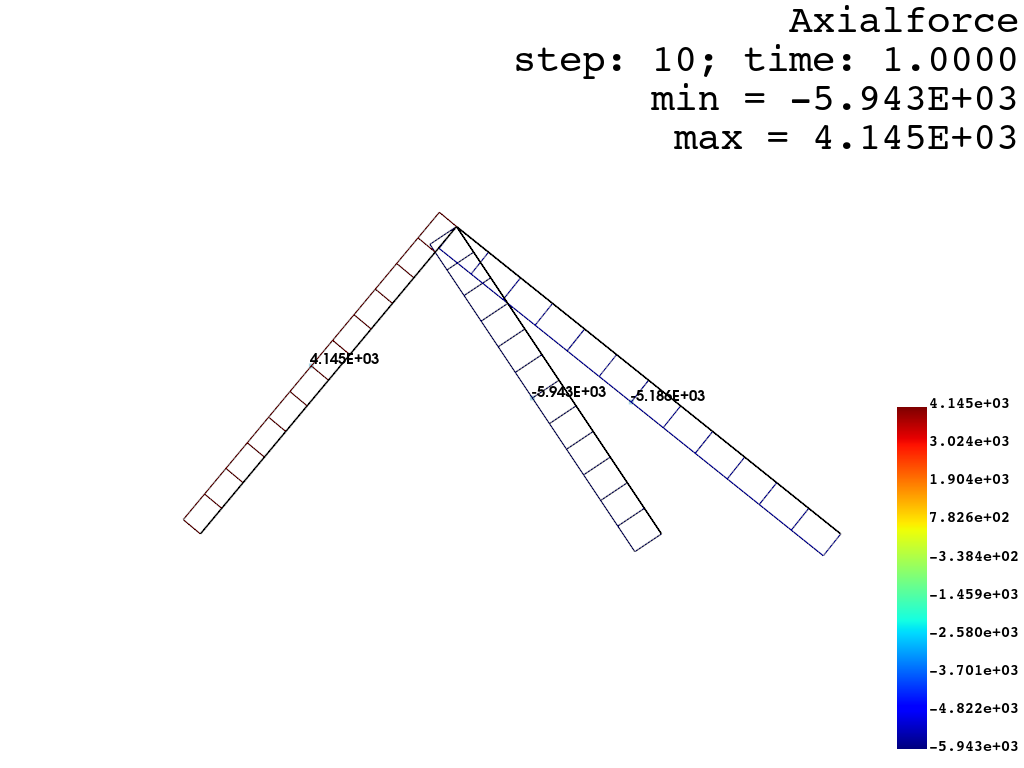

In [8]:
opst.vis.pyvista.set_plot_props(notebook=True)
opst.vis.pyvista.set_plot_colors(truss="black")

fig = opst.vis.pyvista.plot_truss_responses(odb_tag=1, resp_type="axialForce")
fig.show(jupyter_backend="")

Visualize stress, unit corresponds to MPa ($N/mm^2$)

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-1.nc ...

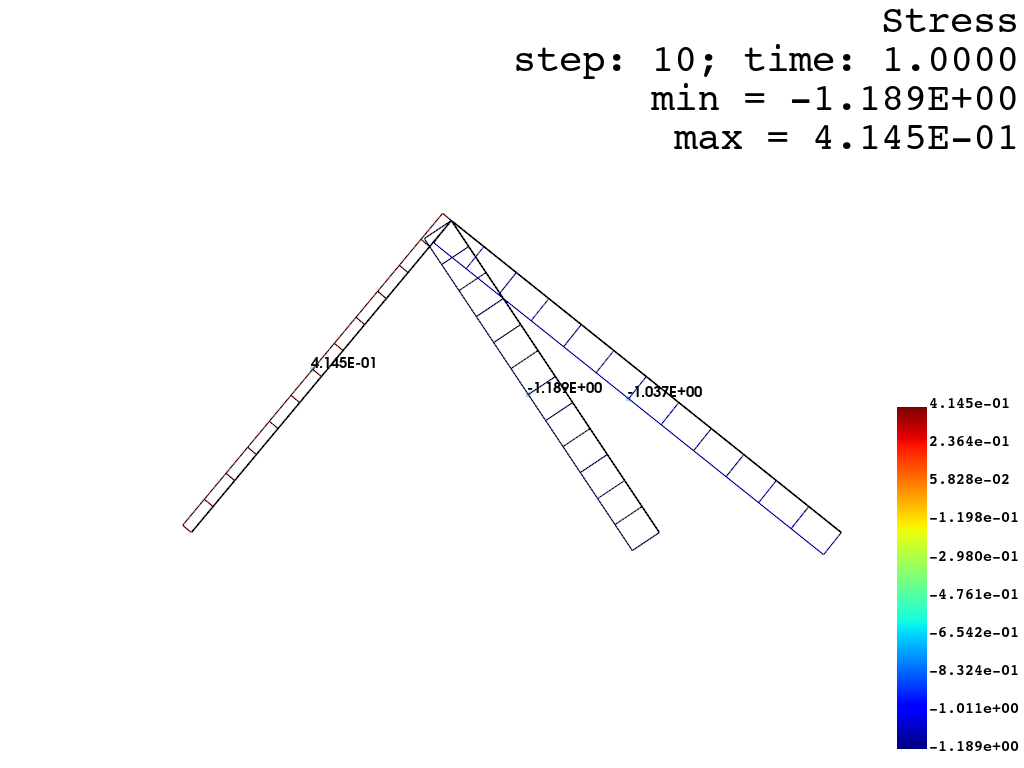

In [9]:
fig = opst.vis.pyvista.plot_truss_responses(odb_tag=1, resp_type="Stress")
fig.show(jupyter_backend="")

### Unit conversion in post-processing

We can now update the unit system in the post-processing. 

Note that ``pre`` must correspond to the base unit system selected earlier (this is a fact). 

``post`` is the target unit system to transform to, which can be anything. 

All conversions are done automatically inside opstool 😀

In [10]:
opst.post.update_unit_system(
    pre={"length": "mm", "force": "N"},
    post={"length": "m", "force": "kN"},
)

After the update, we visualize the axial force, which is ``kN`` at this time. 
We can see that it is 1000 times smaller than before, which is what we expected.

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-1.nc ...

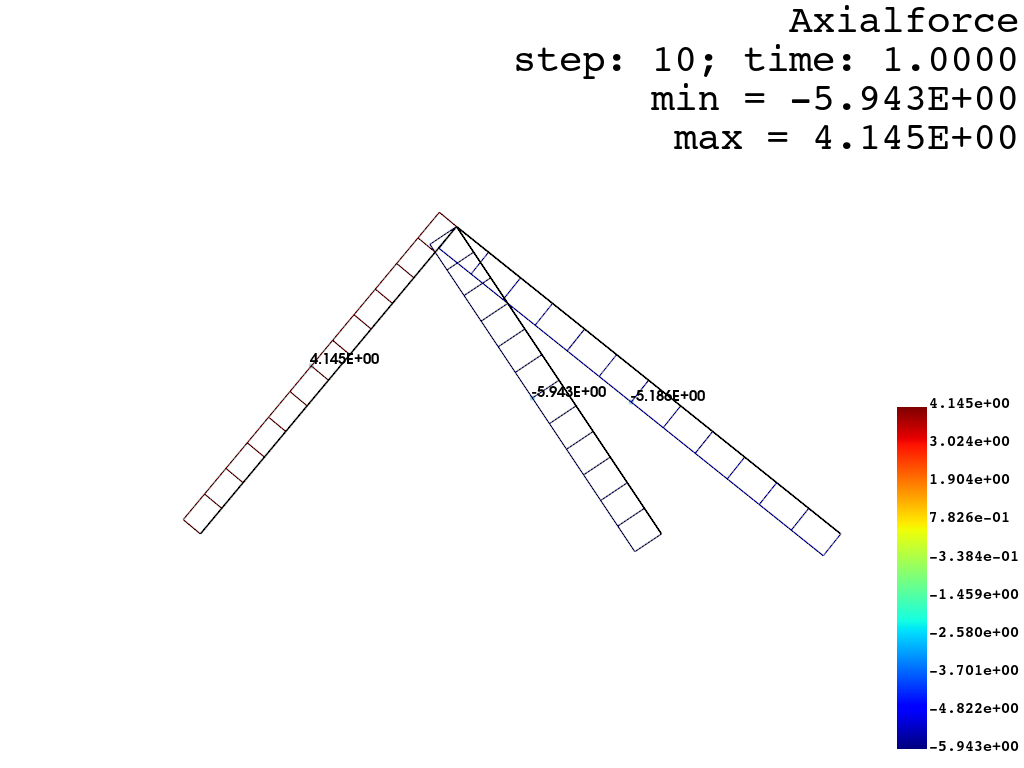

In [11]:
fig = opst.vis.pyvista.plot_truss_responses(odb_tag=1, resp_type="axialForce")
fig.show(jupyter_backend="")

The stress changes from MPa to kPa, which is amplified 1000 times.

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-1.nc ...

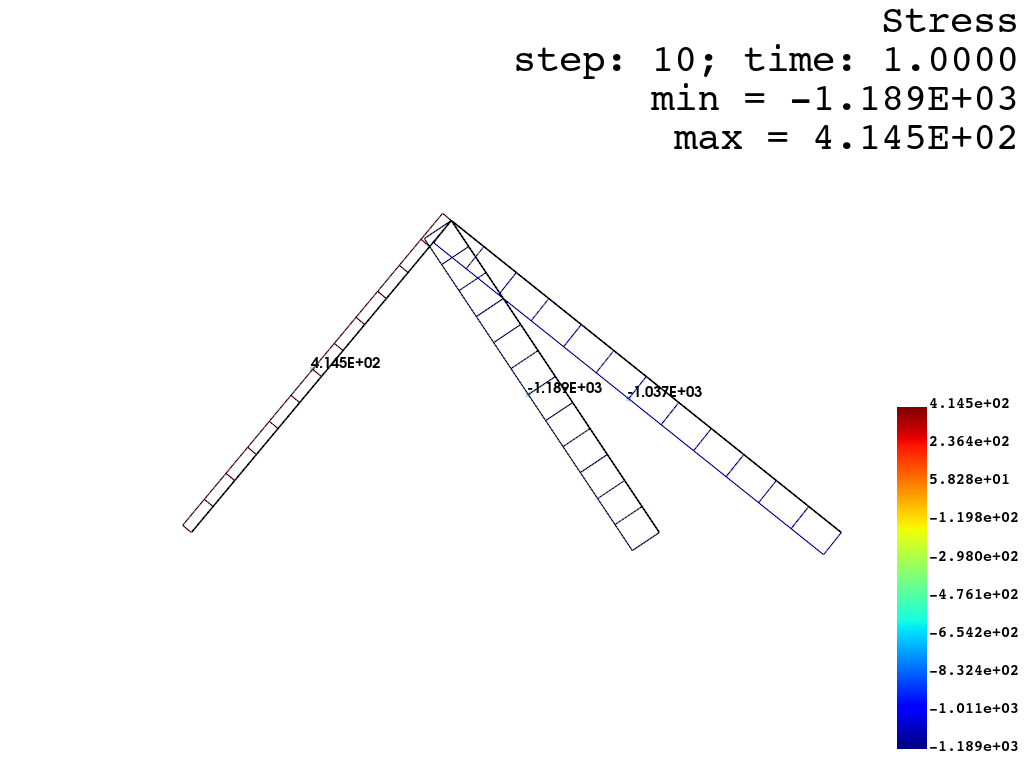

In [12]:
fig = opst.vis.pyvista.plot_truss_responses(odb_tag=1, resp_type="Stress")
fig.show(jupyter_backend="")

### Plot ratio coefficient

Let's look at the unit conversion factors for displacement, axial force, stress, and strain. Note that strain is dimensionless.

In [13]:
node_resp2 = opst.post.get_nodal_responses(odb_tag=1)
ele_resp2 = opst.post.get_element_responses(odb_tag=1, ele_type="Truss")

OPSTOOL ::  Loading all response data from .opstool.output/RespStepData-1.nc ...

OPSTOOL ::  Loading Truss response data from .opstool.output/RespStepData-1.nc ...

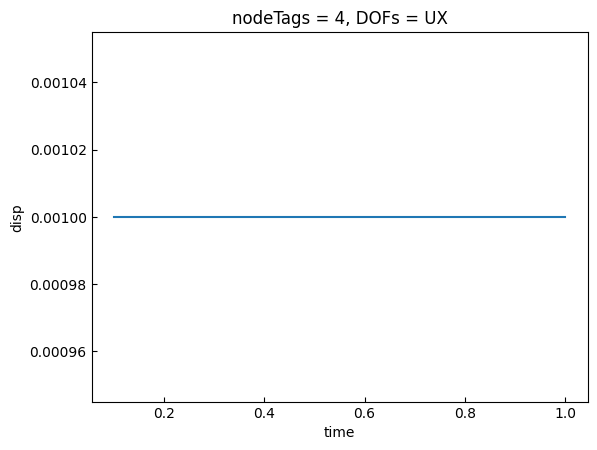

In [14]:
disp = node_resp["disp"].sel(nodeTags=4, DOFs="UX")
disp2 = node_resp2["disp"].sel(nodeTags=4, DOFs="UX")

(disp2 / disp).plot.line(x="time")
plt.show()

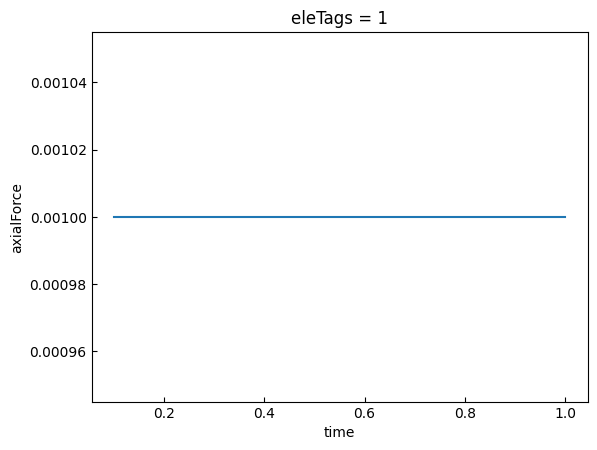

In [15]:
force = ele_resp["axialForce"].sel(eleTags=1)
force2 = ele_resp2["axialForce"].sel(eleTags=1)

(force2 / force).plot.line(x="time")
plt.show()

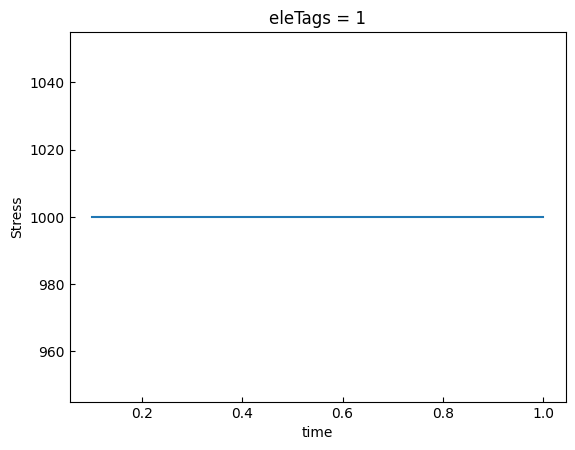

In [16]:
stress = ele_resp["Stress"].sel(eleTags=1)
stress2 = ele_resp2["Stress"].sel(eleTags=1)
ratio = np.round(stress2 / stress, 3)

(ratio).plot.line(x="time")
plt.show()

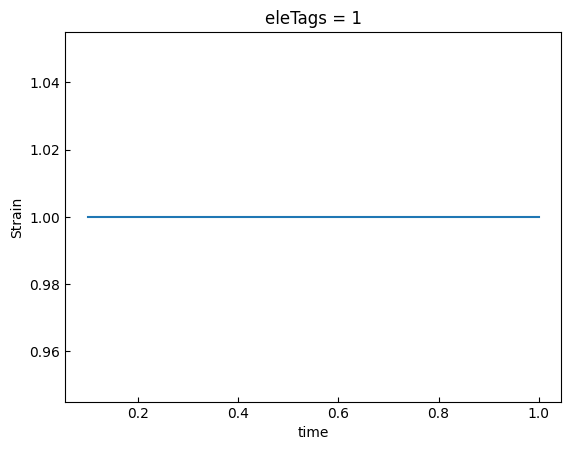

In [17]:
strain = ele_resp["Strain"].sel(eleTags=1)
strain2 = ele_resp2["Strain"].sel(eleTags=1)
ratio = np.round(strain2 / strain, 3)

(ratio).plot.line(x="time")
plt.show()

### Reset unit system

If you wish to reset to the original unit system, you can:

In [18]:
opst.post.reset_unit_system()